In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import math

# The deformation module library is not automatically installed yet, we need to add its path manually
import sys
sys.path.append("../../")

import numpy as np
import matplotlib.pyplot as plt
import torch

import implicitmodules.torch as dm

torch.set_default_tensor_type(torch.FloatTensor)
dm.Utilities.set_compute_backend('torch')

torch.manual_seed(5)

In [2]:
dim = 2
nb_pts = 8

gd_pos = 0.2*torch.randn(nb_pts, dim)
gd_dir = 0.2*torch.randn(nb_pts, dim)

mom_pos = 0.7*torch.randn(nb_pts, dim)
mom_dir = 0.7*torch.randn(nb_pts, dim)

sigma = 0.02#torch.mean(dm.Kernels.distances(gd_pos, gd_pos))

oriented = dm.DeformationModules.OrientedTranslations(dim, nb_pts, sigma, 'vector', nu=0.0001, gd=(gd_pos.clone().requires_grad_(), gd_dir.clone().requires_grad_()), cotan=(mom_pos.clone().requires_grad_(), mom_dir.clone().requires_grad_()))

In [3]:
intermediate_states, intermediate_controls = dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian([oriented]), 400, 'euler', intermediates=True)

In [4]:
trajectories = [torch.stack(trajectory) for trajectory in list(zip(*(state[0].gd[0] for state in intermediate_states)))]

trajectories_dir = [torch.stack(trajectory_dir) for trajectory_dir in list(zip(*(state[0].gd[1] for state in intermediate_states)))]

trajectories_controls = torch.stack(tuple(control[0] for control in intermediate_controls))
trajectories_controls = torch.cat([torch.zeros(1, nb_pts), trajectories_controls]).T

trajectories_dir = [control.repeat(2, 1).T*trajectory_dir for control, trajectory_dir in zip(trajectories_controls, trajectories_dir)]

In [5]:
aabb = dm.Utilities.AABB.build_from_points(torch.cat([trajectory for trajectory in trajectories])).scale(2.)
print("{width}:{height}".format(width=aabb.width, height=aabb.height))

oriented = dm.DeformationModules.OrientedTranslations(dim, nb_pts, sigma, 'orthogonal', gd=(gd_pos.clone().requires_grad_(), gd_dir.clone().requires_grad_()), cotan=(mom_pos.clone().requires_grad_(), mom_dir.clone().requires_grad_()))
width = 256
height = 256
gd_grid = aabb.fill([width, height])
nb_pts_silent = gd_grid.shape[0]
grid = dm.DeformationModules.SilentLandmarks(dim, nb_pts_silent, gd=gd_grid.clone().requires_grad_(), cotan=torch.zeros_like(gd_grid, requires_grad=True))

3.4693751335144043:24.662206649780273


In [6]:
dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian([oriented, grid]), 200, 'euler')

In [7]:
%matplotlib qt5

ax = plt.subplot()

for trajectory, trajectory_dir in zip(trajectories, trajectories_dir):
    plt.plot(trajectory[:, 0], trajectory[:, 1], '-')
    plt.quiver(trajectory[:, 0], trajectory[:, 1], trajectory_dir[:, 0], trajectory_dir[:, 1], scale=10.)

defgrid_x, defgrid_y = dm.Utilities.vec2grid(grid.manifold.gd.detach(), width, height)
dm.Utilities.plot_grid(ax, defgrid_x, defgrid_y, color='blue')

plt.axis('equal')
plt.show()

In [9]:
ax = plt.subplot()

for trajectory, trajectory_dir in zip(trajectories, trajectories_dir):
    plt.plot(trajectory[:, 0], trajectory[:, 1], '-')
    plt.quiver(trajectory[:, 0], trajectory[:, 1], trajectory_dir[:, 0], trajectory_dir[:, 1], scale=100.)

#defgrid_x, defgrid_y = dm.Utilities.vec2grid(grid.manifold.gd.detach(), 17, 32)
#dm.Utilities.plot_grid(ax, defgrid_x, defgrid_y, color='blue')

plt.show()

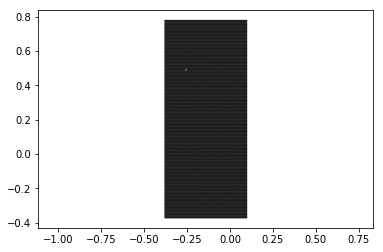

In [ ]:
vector_field = oriented(gd_grid).detach()

plt.quiver(gd_grid.detach().numpy()[:, 0], gd_grid.detach().numpy()[:, 1], vector_field.numpy()[:, 0], vector_field.numpy()[:, 1], scale=100.)
plt.axis('equal')
plt.show()